In [ ]:
# ref https://www.kaggle.com/bulentsiyah/mnist-for-beginners-tensorflow-dnn-cnn-keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import keras
from setuptools.command.setopt import option_base
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer
from tensorflow.python.keras.layers import MaxPooling2D, MaxPool2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten,BatchNormalization,Dropout
from tensorflow.python.keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalizationab
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


train = pd.read_csv("digit-recognizer/train.csv")
test_orj  = pd.read_csv("digit-recognizer/test.csv")

print("Training set has {0[0]} rows and {0[1]} columns".format(train.shape))
print("Test set has {0[0]} rows and {0[1]} columns".format(test_orj.shape))

Training set has 42000 rows and 785 columns
Test set has 28000 rows and 784 columns


In [3]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

/opt/homebrew/Cellar/python36/3.6.2+_254.20170915/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

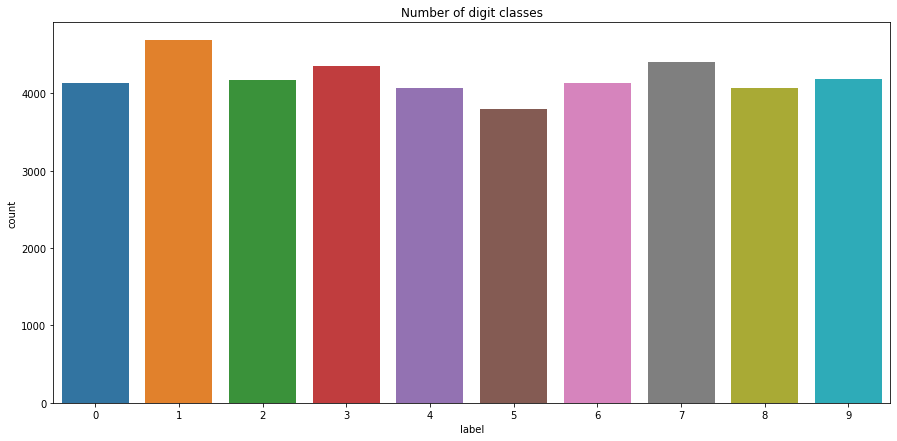

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# visualize number of digits classes
plt.figure(figsize=(15,7))
sns.countplot(Y_train)
plt.title("Number of digit classes")
Y_train.value_counts()

<class 'pandas.core.frame.DataFrame'>


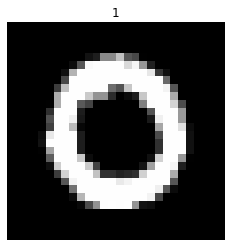

In [7]:
# plot some samples
print(type(X_train))
img = X_train.iloc[1].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test_orj.copy() / 255.0

# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_val shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


In [9]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [11]:
from keras import backend as K
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# Select optimizer
sgd = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
rms_prop = keras.optimizers.RMSprop(lr=1e-4)
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08) 
adamax = keras.optimizers.Adamax(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [12]:
batch_size = 86
num_classes = 10
epochs = 100
input_shape = (28, 28, 1)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64,kernel_size=(3, 3),activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam,
              metrics=['accuracy', recall])

In [14]:
datagenn = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagenn.fit(X_train)

In [17]:
epochs = 3 # TODO: 100 -> 3
history = model.fit_generator(datagenn.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)
result = model.evaluate(x=X_train, y=Y_train)
print('Accuracy:', result[1])

Epoch 1/3
439/439 - 35s - loss: 0.0940 - accuracy: 0.9717 - recall: 0.9679 - val_loss: 0.0391 - val_accuracy: 0.9879 - val_recall: 0.9856
Epoch 2/3
439/439 - 36s - loss: 0.0865 - accuracy: 0.9733 - recall: 0.9694 - val_loss: 0.0350 - val_accuracy: 0.9898 - val_recall: 0.9884
Epoch 3/3
439/439 - 37s - loss: 0.0837 - accuracy: 0.9740 - recall: 0.9703 - val_loss: 0.0327 - val_accuracy: 0.9898 - val_recall: 0.9877
1182/1182 [==============================] - 15s 13ms/step - loss: 0.0260 - accuracy: 0.9917 - recall: 0.9909
Accuracy: 0.9917196035385132


In [18]:
pred_digits_test=np.argmax(model.predict(test),axis=1)
image_id_test=[]
for i in range (len(pred_digits_test)):
    image_id_test.append(i+1)
d={'ImageId':image_id_test,'Label':pred_digits_test}
answer=pd.DataFrame(d)
answer.to_csv('/tmp/result.csv',index=False)